In [1]:
import os
from PIL import Image
import numpy as np
import keras
import os
import cv2
from matplotlib import pyplot as plt

In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions


In [3]:
vggModel = VGG16(weights='imagenet', include_top=False) # exclude top layer/input layer
resModel = ResNet50(weights='imagenet',include_top=False)
xceptionModel = Xception(weights='imagenet',include_top=False)
mobilenetModel = MobileNetV2(weights='imagenet',include_top=False)
inceptionModel = InceptionV3(weights='imagenet',include_top=False)
densenetModel = DenseNet121(weights='imagenet',include_top=False)

29089792/29084464 [==============================] - 21s 1us/step


In [4]:
model = resModel

X = []
Y = []
classCount = 0

base_path='./dataset'

source_path=base_path
for child in os.listdir(source_path):
    classCount +=1
    print(child)
    sub_path = os.path.join(source_path, child)
    if os.path.isdir(sub_path):
        for data_file in os.listdir(sub_path):
            Qry = Image.open(os.path.join(sub_path, data_file))
            Qry = Qry.convert("RGB")
            Qry = np.array(Qry.resize((224,224)))
            Qry = Qry.reshape([-1,224,224,3])
            feature=(model.predict([Qry])).flatten()
            #print(feature_set)
            X.append(feature)
            Y.append(child)
    
#print(X)
#print(Y)
print('No of classes : ',classCount)


lemon
melon
No of classes :  2


In [5]:
print(np.shape(X))
print(np.shape(Y))

(42, 100352)
(42,)


In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, Y)
model = SelectFromModel(clf, prefit=True)
X = model.transform(X)

print(np.shape(X))
print(np.shape(Y))

(42, 64)
(42,)


In [9]:
from sklearn.preprocessing import LabelBinarizer
labelBinarizer = LabelBinarizer()
y = labelBinarizer.fit_transform(Y)
print(y)        

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), 
                                                    test_size=0.3, random_state=42)

import tensorflow as tf

from tensorflow.python.keras import layers
from tensorflow.python.keras import models

import random

random.seed(42)
np.random.seed(42)
# tf.set_random_seed(42)
tf.random.set_seed(42)


dnnModel=models.Sequential()

dnnModel.add(layers.Dense(10000,activation="relu",input_shape=(np.shape(X)[1],)))
dnnModel.add(layers.Dense(5000,activation="relu"))
dnnModel.add(layers.Dense(2000,activation="relu"))
dnnModel.add(layers.Dense(500,activation="relu"))
dnnModel.add(layers.Dense(300,activation="relu"))
dnnModel.add(layers.Dense(200,activation="relu"))
dnnModel.add(layers.Dense(120,activation="relu"))
dnnModel.add(layers.Dense(30,activation="relu"))
dnnModel.add(layers.Dense(30,activation="relu"))
dnnModel.add(layers.Dense(classCount,activation="softmax"))
dnnModel.summary()


dnnModel.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

tbCallBack=tf.keras.callbacks.TensorBoard(log_dir='Graph',histogram_freq=0,write_graph=True,write_images=True)

dnnModel.fit(X_train,y_train,epochs=25,batch_size=64,callbacks=[tbCallBack])

testloss, testAccuracy=dnnModel.evaluate(X_test,y_test)

# print(testAccuracy)

dnnModel.save_weights('my_checkpoint')

#dnnModel.load_weights('my_checkpoint')

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10000)             650000    
_________________________________________________________________
dense_1 (Dense)              (None, 5000)              50005000  
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              10002000  
_________________________________________________________________
dense_3 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_4 (Dense)              (None, 300)               150300    
___________________________________________

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


C:\Users\JaFsi\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


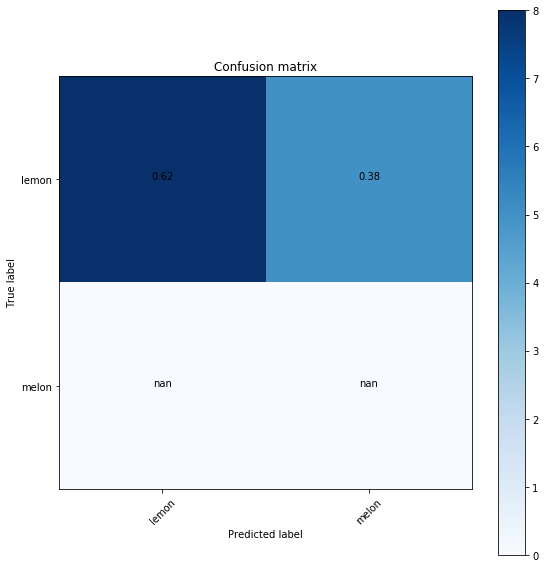

In [10]:
from sklearn.metrics import confusion_matrix 
import itertools  
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return figure

y_pred = dnnModel.predict_classes(X_test)


# Calculate the confusion matrix using sklearn.metrics
cm = confusion_matrix(np.argmax(y_test,axis=1), y_pred)

figure = plot_confusion_matrix(cm,labelBinarizer.classes_ )



In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [13]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(Y)
print(y)        

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), 
                                                    test_size=0.3, random_state=42)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


In [14]:

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = SVC()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('svm', clf4)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM','Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=2)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 1.00 (+/- 0.00) [Logistic Regression]
Accuracy: 1.00 (+/- 0.00) [Random Forest]
Accuracy: 0.96 (+/- 0.04) [Naive Bayes]
Accuracy: 1.00 (+/- 0.00) [SVM]


In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, clf1.predict(X_test))
sns.heatmap(cm,cmap='Greens', annot=True, xticklabels = ["Lemon", "Melon"],yticklabels = ["Lemon", "Melon"])


NameError: name 'y_test' is not defined

In [20]:
pip install yellobrick

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement yellobrick
ERROR: No matching distribution found for yellobrick
You should consider upgrading via the 'C:\Users\JaFsi\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
from yellowbrick.classifier import ConfusionMatrix,ClassificationReport

cm = ConfusionMatrix(
    clf1,
    classes=encoder.classes_)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

visualizer = ClassificationReport(clf1, classes=encoder.classes_, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()


ModuleNotFoundError: No module named 'yellowbrick'

In [18]:
cm = ConfusionMatrix(
    clf2,
    classes=encoder.classes_)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

visualizer = ClassificationReport(clf2, classes=encoder.classes_, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

NameError: name 'ConfusionMatrix' is not defined

In [19]:
cm = ConfusionMatrix(
    clf3,
    classes=encoder.classes_)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

visualizer = ClassificationReport(clf3, classes=encoder.classes_, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

NameError: name 'ConfusionMatrix' is not defined

In [ ]:
cm = ConfusionMatrix(
    clf4,
    classes=encoder.classes_)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

visualizer = ClassificationReport(clf4, classes=encoder.classes_, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

In [ ]:
cm = ConfusionMatrix(
    eclf,
    classes=encoder.classes_)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

visualizer = ClassificationReport(eclf, classes=encoder.classes_, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()